<a href="https://colab.research.google.com/github/sayakpaul/Emotion-Detection-using-Deep-Learning/blob/master/Emotion_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Select TensorFlow 2.0 environment
%tensorflow_version 2.x

TensorFlow 2.x selected.


You need to get your API key from your Kaggle account to be able to proceed with the following. 

In [0]:
# Google Colab imports for setting up Kaggle
from google.colab import files
files.upload()

In [0]:
# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the data
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [0]:
# Unzip dataset
!unzip -qq icml_face_data.csv.zip
!unzip -qq test.csv.zip
!unzip -qq train.csv.zip

In [0]:
# General imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
# Load up the training dataset
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
# Class distribution
train["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class imbalance noticed.

In [9]:
# Load test dataset
test = pd.read_csv("test.csv")
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


Note on the label mapping:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [0]:
# Function to clean the dataset
# Taken from http://bit.ly/37AUk7f
def clean_data(dataframe):
    image_pixels = np.zeros(shape=(len(dataframe), 48, 48))
    labels = np.zeros(shape=(len(dataframe), ))
    for (i, row) in tqdm(dataframe.iterrows()):
        image = np.fromstring(row["pixels"], dtype=int, sep=' ')
        image = image.reshape(48, 48)
        image = image.astype("float")/255
        
        image_pixels[i] = image
        labels[i] = row["emotion"]
    
    return (image_pixels, labels)

In [11]:
# Clean the training dataset and verify the shapes
(train_pixels, train_labels) = clean_data(train)
train_pixels.shape, train_labels.shape

28709it [00:05, 5174.45it/s]


((28709, 48, 48), (28709,))

In [0]:
# sklearn and other utility imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [0]:
# One-hot encode the labels
le = LabelEncoder().fit(train_labels)
train_labels = to_categorical(le.transform(train_labels), 7)

In [14]:
train_labels.shape

(28709, 7)

In [15]:
# Split the training data into further partial training and validation data
(trainX, valX, trainY, valY) = train_test_split(train_pixels,
    train_labels, test_size=0.15, stratify=train_labels, random_state=42)
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [16]:
# Serialize the data for later reproducibility
np.save("trainX.npy", trainX), np.save("trainY.npy", trainY)
np.save("valX.npy", valX), np.save("valY.npy", valY)

(None, None)

In [17]:
# Load it like this
trainX, trainY = np.load("trainX.npy"), np.load("trainY.npy")
valX, valY = np.load("valX.npy"), np.load("valY.npy")
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# Define the label mapping
LABELS = {
    0: "Angry", 
    1: "Disgust", 
    2: "Fear",
    3: "Happy", 
    4: "Sad", 
    5: "Surprise", 
    6: "Neutral"
}

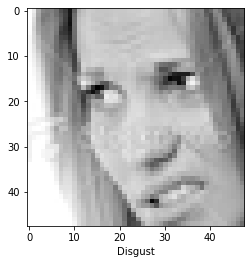

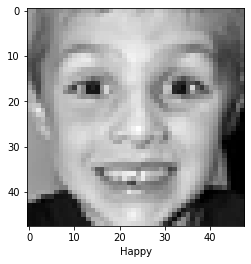

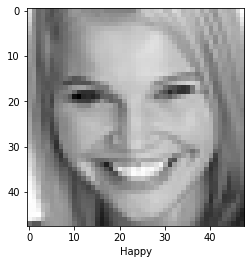

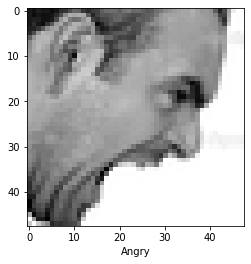

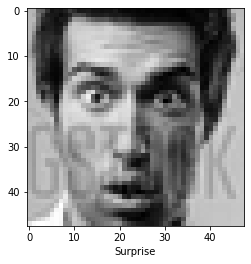

In [20]:
# Spot check the dataset
train_idx = np.random.choice(len(trainX), 5)
for id in train_idx:
    plt.imshow(trainX[id].reshape(48, 48), cmap="gray")
    plt.xlabel(LABELS[np.argmax(trainY[id])])
    plt.show()

For modeling purposes, we are going to use the following three architectures:
- Shallow fully connected network
- Mini InceptionNet or Mini GoogLeNet
- Mini VGGNet

For architectural details and discussions follow this article: https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/. 

In [0]:
# Comes from http://bit.ly/2U8ntCX
!wget https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py

In [0]:
# PyImageSearch imports
from models import MiniVGGNetModel
from models import minigooglenet_functional
from models import shallownet_sequential

In [0]:
# Convnets would require a channel dimension
trainX = trainX.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)

In [0]:
# Set up wandb
!pip install wandb
!wandb login

In [0]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

In [0]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
# Train our first shallow model
wandb.init(project="emotion-detection", entity="sayakpaul", id="shallow-convnet")
shallow_model = shallownet_sequential(48, 48, 1, len(LABELS))
shallow_model.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
shallow_model.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS),
               EarlyStopping(patience=5, restore_best_weights=True)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24402/24402 [==============================] - 12s 473us/sample - loss: 1.6707 - accuracy: 0.3496 - val_loss: 1.5725 - val_accuracy: 0.4086
Epoch 2/50
24402/24402 [==============================] - 4s 161us/sample - loss: 1.4411 - accuracy: 0.4560 - val_loss: 1.5159 - val_accuracy: 0.4191
Epoch 3/50
24402/24402 [==============================] - 4s 166us/sample - loss: 1.3046 - accuracy: 0.5113 - val_loss: 1.5106 - val_accuracy: 0.4305
Epoch 4/50
24402/24402 [==============================] - 4s 160us/sample - loss: 1.1790 - accuracy: 0.5676 - val_loss: 1.5131 - val_accuracy: 0.4418
Epoch 5/50
24402/24402 [==============================] - 4s 166us/sample - loss: 1.0693 - accuracy: 0.6138 - val_loss: 1.5360 - val_accuracy: 0.4514
Epoch 6/50
24402/24402 [==============================] - 4s 162us/sample - loss: 0.9691 - accuracy: 0.6528 - val_loss: 1.5535 - val_accuracy: 0.4518
Epoch 7/50
24402/24402 [==========================

The model terribly overfits. Let's try out the other variants. 

In [29]:
# Train a mini inception net
wandb.init(project="emotion-detection", entity="sayakpaul", id="miniinception-net")
inception_net = minigooglenet_functional(48, 48, 1, len(LABELS))
inception_net.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
inception_net.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS),
               EarlyStopping(patience=5, restore_best_weights=True)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24402/24402 [==============================] - 44s 2ms/sample - loss: 1.6965 - accuracy: 0.3152 - val_loss: 1.5769 - val_accuracy: 0.3875
Epoch 2/50
24402/24402 [==============================] - 39s 2ms/sample - loss: 1.3275 - accuracy: 0.4958 - val_loss: 1.3844 - val_accuracy: 0.4662
Epoch 3/50
24402/24402 [==============================] - 40s 2ms/sample - loss: 1.1703 - accuracy: 0.5587 - val_loss: 1.2896 - val_accuracy: 0.4999
Epoch 4/50
24402/24402 [==============================] - 41s 2ms/sample - loss: 1.0896 - accuracy: 0.5936 - val_loss: 1.2456 - val_accuracy: 0.5342
Epoch 5/50
24402/24402 [==============================] - 40s 2ms/sample - loss: 1.0178 - accuracy: 0.6194 - val_loss: 1.1717 - val_accuracy: 0.5603
Epoch 6/50
24402/24402 [==============================] - 40s 2ms/sample - loss: 0.9557 - accuracy: 0.6415 - val_loss: 1.1800 - val_accuracy: 0.5828
Epoch 7/50
24402/24402 [==============================] -

In [30]:
# Train a mini VGG net
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-net")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS),
               EarlyStopping(patience=5, restore_best_weights=True)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24224/24402 [============================>.] - ETA: 0s - loss: 1.8384 - accuracy: 0.3645

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 9s 357us/sample - loss: 1.8358 - accuracy: 0.3650 - val_loss: 1.4292 - val_accuracy: 0.4574
Epoch 2/50
24402/24402 [==============================] - 7s 293us/sample - loss: 1.3762 - accuracy: 0.4754 - val_loss: 1.4673 - val_accuracy: 0.4541
Epoch 3/50
24402/24402 [==============================] - 7s 295us/sample - loss: 1.2610 - accuracy: 0.5232 - val_loss: 1.3198 - val_accuracy: 0.5013
Epoch 4/50
24402/24402 [==============================] - 7s 300us/sample - loss: 1.1733 - accuracy: 0.5597 - val_loss: 1.2651 - val_accuracy: 0.5168
Epoch 5/50
24402/24402 [==============================] - 8s 311us/sample - loss: 1.1138 - accuracy: 0.5832 - val_loss: 1.2914 - val_accuracy: 0.5226
Epoch 6/50
24402/24402 [==============================] - 8s 319us/sample - loss: 1.0487 - accuracy: 0.6077 - val_loss: 1.2543 - val_accuracy: 0.5289
Epoch 7/50
24402/24402 [==============================] - 8s 308us/sample - loss: 0.9866 - accuracy: 0.6324 - v

In [0]:
# Instantiate a data augmentation pipeline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2)
val_aug = ImageDataGenerator()

In [32]:
# Train a mini VGG net with data augmentation & SGD
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-net-da-sgd")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(train_aug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=np.ceil(len(trainX)/64),
    validation_data=val_aug.flow(valX, valY, batch_size=64), 
    validation_steps=np.ceil(len(valX)/64) ,
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS),
               EarlyStopping(patience=5, restore_best_weights=True)])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 382.0 steps, validate for 68.0 steps
Epoch 1/50
381/382 [============================>.] - ETA: 0s - loss: 2.4246 - accuracy: 0.1944

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


382/382 [==============================] - 12s 31ms/step - loss: 2.4240 - accuracy: 0.1945 - val_loss: 1.8179 - val_accuracy: 0.2719
Epoch 2/50
382/382 [==============================] - 11s 28ms/step - loss: 1.9648 - accuracy: 0.2374 - val_loss: 1.7142 - val_accuracy: 0.3169
Epoch 3/50
382/382 [==============================] - 11s 28ms/step - loss: 1.8344 - accuracy: 0.2634 - val_loss: 1.7271 - val_accuracy: 0.3139
Epoch 4/50
382/382 [==============================] - 11s 28ms/step - loss: 1.7871 - accuracy: 0.2818 - val_loss: 1.6877 - val_accuracy: 0.3320
Epoch 5/50
382/382 [==============================] - 11s 30ms/step - loss: 1.7530 - accuracy: 0.2958 - val_loss: 1.6843 - val_accuracy: 0.3313
Epoch 6/50
382/382 [==============================] - 11s 28ms/step - loss: 1.7362 - accuracy: 0.3001 - val_loss: 1.8613 - val_accuracy: 0.2433
Epoch 7/50
382/382 [==============================] - 11s 28ms/step - loss: 1.7115 - accuracy: 0.3135 - val_loss: 1.6153 - val_accuracy: 0.3696
Epo

Let's train the network with cylical learning rates. You can learn more about it from here: https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/. 

In [0]:
# Get the CLR callback
!wget https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/clr_callback.py

In [0]:
from clr_callback import CyclicLR

In [0]:
# Compute the step size and initialize the cyclic learning
# rate method
step_size = 8 * np.ceil(len(trainX)//64)
clr = CyclicLR(
	mode="triangular",
	base_lr=1e-5,
	max_lr=1e-3,
	step_size=step_size)

In [37]:
# Train a mini VGG net with data augmentation, SGD & CLR
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-net-daug-sgd-clr")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
vgg_net.fit(train_aug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=np.ceil(len(trainX)/64),
    validation_data=val_aug.flow(valX, valY, batch_size=64), 
    validation_steps=np.ceil(len(valX)/64) ,
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS),
    EarlyStopping(patience=5, restore_best_weights=True),
    clr])

  ...
    to  
  ['...']
Train for 382.0 steps, validate for 68.0 steps
Epoch 1/50
381/382 [============================>.] - ETA: 0s - loss: 3.1788 - accuracy: 0.1455

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


382/382 [==============================] - 12s 31ms/step - loss: 3.1783 - accuracy: 0.1457 - val_loss: 2.0538 - val_accuracy: 0.2097
Epoch 2/50
382/382 [==============================] - 10s 27ms/step - loss: 3.0211 - accuracy: 0.1590 - val_loss: 2.4739 - val_accuracy: 0.2034
Epoch 3/50
382/382 [==============================] - 10s 27ms/step - loss: 2.8765 - accuracy: 0.1718 - val_loss: 2.3809 - val_accuracy: 0.2141
Epoch 4/50
382/382 [==============================] - 10s 27ms/step - loss: 2.7644 - accuracy: 0.1762 - val_loss: 2.3144 - val_accuracy: 0.2113
Epoch 5/50
382/382 [==============================] - 10s 27ms/step - loss: 2.6537 - accuracy: 0.1874 - val_loss: 2.0491 - val_accuracy: 0.2703
Epoch 6/50
382/382 [==============================] - 11s 28ms/step - loss: 2.5536 - accuracy: 0.1897 - val_loss: 2.0896 - val_accuracy: 0.2266
Epoch 7/50
382/382 [==============================] - 10s 27ms/step - loss: 2.4507 - accuracy: 0.1992 - val_loss: 1.9503 - val_accuracy: 0.2986
Epo

Jeremy Howard discussed a very nice idea of progressively increasing the number of channels in the initial layers of a Convnet while keeping the kernel size to 3x3. This is discussed here: https://youtu.be/hPQKzsjTyyQ?t=3700. 

In [0]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
import math

In [0]:
class MiniVGGNetModel(Model):
	def __init__(self, classes, channels, init_kernel_size=3, chanDim=-1):
		# call the parent constructor
		super(MiniVGGNetModel, self).__init__()

		# determine the number of channels to output in the first
		# conv layer
		outChannels = 2**math.floor(math.log2(channels*init_kernel_size*init_kernel_size))

		# initialize the layers in the first (CONV => RELU) * 2 => POOL
		# layer set
		self.conv1A = Conv2D(outChannels, (3, 3), strides=1, padding="same")
		self.act1A = Activation("relu")
		self.bn1A = BatchNormalization(axis=chanDim)
		self.conv1B = Conv2D(outChannels*2, (3, 3), strides=2, padding="same")
		self.act1B = Activation("relu")
		self.bn1B = BatchNormalization(axis=chanDim)
		self.pool1 = MaxPooling2D(pool_size=(2, 2))
  
		# initialize the layers in the second (CONV => RELU) => POOL
		# layer set
		self.conv2A = Conv2D(outChannels*4, (3, 3), strides=2, padding="same")
		self.act2A = Activation("relu")
		self.bn2A = BatchNormalization(axis=chanDim)
		self.pool2 = MaxPooling2D(pool_size=(2, 2))

		# initialize the layers in our fully-connected layer set
		self.flatten = GlobalAveragePooling2D()
		self.dense3 = Dense(512)
		self.act3 = Activation("relu")
		self.bn3 = BatchNormalization()
		self.do3 = Dropout(0.5)

		# initialize the layers in the softmax classifier layer set
		self.dense4 = Dense(classes)
		self.softmax = Activation("softmax")

	def call(self, inputs):
		# build the first (CONV => RELU) * 2 => POOL layer set
		x = self.conv1A(inputs)
		x = self.act1A(x)
		x = self.bn1A(x)
		x = self.conv1B(x)
		x = self.act1B(x)
		x = self.bn1B(x)
		x = self.pool1(x)
	
		# build the second (CONV => RELU) => POOL
		# layer set
		x = self.conv2A(x)
		x = self.act2A(x)
		x = self.bn2A(x)
		x = self.pool2(x)

		# build our FC layer set
		x = self.flatten(x)
		x = self.dense3(x)
		x = self.act3(x)
		x = self.bn3(x)
		x = self.do3(x)

		# build the softmax classifier
		x = self.dense4(x)
		x = self.softmax(x)

		# return the constructed model
		return x

In [43]:
mini_vgg_v2 = MiniVGGNetModel(len(LABELS), channels=1)
for layer in mini_vgg_v2.layers:
    print(layer.get_config())

{'name': 'conv2d_10', 'trainable': True, 'dtype': 'float32', 'filters': 8, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'activation_20', 'trainable': True, 'dtype': 'float32', 'activation': 'relu'}
{'name': 'batch_normalization_15', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {

In [44]:
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-prog-channels")
mini_vgg_v2 = MiniVGGNetModel(len(LABELS), channels=1)
mini_vgg_v2.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
mini_vgg_v2.fit(train_aug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=np.ceil(len(trainX)/64),
    validation_data=val_aug.flow(valX, valY, batch_size=64), 
    validation_steps=np.ceil(len(valX)/64),
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS),
               EarlyStopping(patience=5, restore_best_weights=True)])

  ...
    to  
  ['...']
Train for 382.0 steps, validate for 68.0 steps
Epoch 1/50
379/382 [============================>.] - ETA: 0s - loss: 2.2010 - accuracy: 0.1981

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


382/382 [==============================] - 10s 27ms/step - loss: 2.1995 - accuracy: 0.1985 - val_loss: 1.8372 - val_accuracy: 0.2498
Epoch 2/50
382/382 [==============================] - 9s 24ms/step - loss: 1.9048 - accuracy: 0.2380 - val_loss: 1.7660 - val_accuracy: 0.2826
Epoch 3/50
382/382 [==============================] - 9s 24ms/step - loss: 1.8120 - accuracy: 0.2637 - val_loss: 1.7393 - val_accuracy: 0.2905
Epoch 4/50
382/382 [==============================] - 9s 24ms/step - loss: 1.7710 - accuracy: 0.2754 - val_loss: 1.7932 - val_accuracy: 0.2730
Epoch 5/50
382/382 [==============================] - 9s 24ms/step - loss: 1.7532 - accuracy: 0.2842 - val_loss: 1.7297 - val_accuracy: 0.2895
Epoch 6/50
382/382 [==============================] - 9s 25ms/step - loss: 1.7405 - accuracy: 0.2907 - val_loss: 1.7265 - val_accuracy: 0.2884
Epoch 7/50
382/382 [==============================] - 9s 24ms/step - loss: 1.7329 - accuracy: 0.2937 - val_loss: 1.7738 - val_accuracy: 0.2858
Epoch 8/5

In [45]:
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-prog-channels-2")
mini_vgg_v2 = MiniVGGNetModel(len(LABELS), channels=1)
mini_vgg_v2.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
mini_vgg_v2.fit(train_aug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=np.ceil(len(trainX)/64),
    validation_data=val_aug.flow(valX, valY, batch_size=64), 
    validation_steps=np.ceil(len(valX)/64),
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

  ...
    to  
  ['...']
Train for 382.0 steps, validate for 68.0 steps
Epoch 1/50
381/382 [============================>.] - ETA: 0s - loss: 2.2321 - accuracy: 0.1911

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


382/382 [==============================] - 10s 27ms/step - loss: 2.2315 - accuracy: 0.1912 - val_loss: 1.8486 - val_accuracy: 0.2524
Epoch 2/50
382/382 [==============================] - 10s 25ms/step - loss: 1.9289 - accuracy: 0.2270 - val_loss: 1.7736 - val_accuracy: 0.2712
Epoch 3/50
382/382 [==============================] - 9s 25ms/step - loss: 1.8328 - accuracy: 0.2515 - val_loss: 1.7635 - val_accuracy: 0.2751
Epoch 4/50
382/382 [==============================] - 9s 24ms/step - loss: 1.7921 - accuracy: 0.2659 - val_loss: 1.7527 - val_accuracy: 0.2740
Epoch 5/50
382/382 [==============================] - 9s 25ms/step - loss: 1.7716 - accuracy: 0.2717 - val_loss: 1.7458 - val_accuracy: 0.2935
Epoch 6/50
382/382 [==============================] - 9s 24ms/step - loss: 1.7670 - accuracy: 0.2776 - val_loss: 1.7440 - val_accuracy: 0.2958
Epoch 7/50
382/382 [==============================] - 9s 25ms/step - loss: 1.7487 - accuracy: 0.2876 - val_loss: 1.7169 - val_accuracy: 0.3037
Epoch 8/

In [46]:
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-prog-channels-wo_da")
mini_vgg_v2 = MiniVGGNetModel(len(LABELS), channels=1)
mini_vgg_v2.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
mini_vgg_v2.fit(trainX, trainY, 
    batch_size=64,
    validation_data=(valX, valY),
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24192/24402 [============================>.] - ETA: 0s - loss: 2.1178 - accuracy: 0.2321

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 4s 155us/sample - loss: 2.1167 - accuracy: 0.2320 - val_loss: 1.8309 - val_accuracy: 0.2287
Epoch 2/50
24402/24402 [==============================] - 3s 110us/sample - loss: 1.7937 - accuracy: 0.3144 - val_loss: 1.7025 - val_accuracy: 0.3192
Epoch 3/50
24402/24402 [==============================] - 3s 113us/sample - loss: 1.6844 - accuracy: 0.3448 - val_loss: 1.6760 - val_accuracy: 0.3360
Epoch 4/50
24402/24402 [==============================] - 3s 113us/sample - loss: 1.6309 - accuracy: 0.3647 - val_loss: 1.6763 - val_accuracy: 0.3455
Epoch 5/50
24402/24402 [==============================] - 3s 116us/sample - loss: 1.5987 - accuracy: 0.3753 - val_loss: 1.6276 - val_accuracy: 0.3664
Epoch 6/50
24402/24402 [==============================] - 3s 115us/sample - loss: 1.5752 - accuracy: 0.3836 - val_loss: 1.5963 - val_accuracy: 0.3771
Epoch 7/50
24402/24402 [==============================] - 3s 119us/sample - loss: 1.5590 - accuracy: 0.3948 - v

Let's try Layer-Wise Sequential Unit Variance (LSUV) to initialize our network. LSUV was introduced in a paper called [All you need is a good init](https://arxiv.org/pdf/1511.06422.pdf) by Mishkin et. al. I have referred the Keras implementation from here: https://github.com/suvojit-0x55aa/LSUV-Keras. 

In [0]:
from tensorflow.keras.models import Sequential

In [0]:
def seq_mini_vgg(channels=1, init_kernel_size=3, classes=7):
    
    # determine the number of channels to output in the first
    # conv layer
    outChannels = 2**math.floor(math.log2(channels*init_kernel_size*init_kernel_size))

    mini_vgg_seq = Sequential()
    
    mini_vgg_seq.add(Conv2D(outChannels, (3, 3), strides=1, padding="same", activation="relu", 
        input_shape=(48, 48, channels)))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(Conv2D(outChannels*2, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    mini_vgg_seq.add(Conv2D(outChannels*4, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(Conv2D(outChannels*8, (3, 3), strides=2, padding="same", activation="relu"))
    mini_vgg_seq.add(BatchNormalization(axis=-1))
    mini_vgg_seq.add(MaxPooling2D(pool_size=(2, 2)))
    
    mini_vgg_seq.add(GlobalAveragePooling2D())
    mini_vgg_seq.add(Dense(512, activation="relu"))
    mini_vgg_seq.add(BatchNormalization())
    mini_vgg_seq.add(Dropout(0.5))
    mini_vgg_seq.add(Dense(classes, activation="softmax"))
    
    return mini_vgg_seq

In [0]:
!wget https://raw.githubusercontent.com/suvojit-0x55aa/LSUV-Keras/master/lib/lsuv.py

In [0]:
from lsuv import LSUVinitialize

In [62]:
mini_vgg_v2 = seq_mini_vgg(classes=len(LABELS))
mini_vgg_v2.compile(loss="categorical_crossentropy", optimizer="sgd",
	metrics=["accuracy"])
mini_vgg_v2 = LSUVinitialize(mini_vgg_v2, trainX[:64,:,:,:])

Init Layer conv2d_41
0.27400485
Init Layer conv2d_42
0.3679965
Init Layer conv2d_43
0.13762803
Init Layer conv2d_44
0.14265084
Init Layer dense_28
0.3836396
dense_29 too small
LSUV: total layers initialized 5


In [63]:
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-prog-channels-wda-lsuv")
mini_vgg_v2.fit(trainX, trainY, 
    batch_size=64,
    validation_data=(valX, valY),
    epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", validation_data=(valX, valY), labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24402/24402 [==============================] - 4s 172us/sample - loss: 2.4063 - accuracy: 0.2014 - val_loss: 1.7923 - val_accuracy: 0.2847
Epoch 2/50
24402/24402 [==============================] - 3s 121us/sample - loss: 1.9124 - accuracy: 0.2701 - val_loss: 1.7389 - val_accuracy: 0.3097
Epoch 3/50
24402/24402 [==============================] - 3s 117us/sample - loss: 1.7564 - accuracy: 0.3097 - val_loss: 1.6880 - val_accuracy: 0.3346
Epoch 4/50
24402/24402 [==============================] - 3s 118us/sample - loss: 1.6859 - accuracy: 0.3373 - val_loss: 1.6569 - val_accuracy: 0.3462
Epoch 5/50
24402/24402 [==============================] - 3s 119us/sample - loss: 1.6473 - accuracy: 0.3538 - val_loss: 1.6410 - val_accuracy: 0.3511
Epoch 6/50
24402/24402 [==============================] - 3s 120us/sample - loss: 1.6171 - accuracy: 0.3676 - val_loss: 1.6230 - val_accuracy: 0.3559
Epoch 7/50
24402/24402 [===========================